In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Audit Report Tracker (Sharepoint List),24.445644,24.445644,24.445644,1
VMWare,812.346069,18.891769,40.461855,43
Azure Private DNS,1073.235107,56.486058,128.953616,19
Logging in Python,1080.191161,77.156512,222.980833,14
C# Basics,1097.483530,35.402695,77.199476,31
Azure AD Authentication,1183.730371,91.056182,253.838087,13
Azure Functions + Visual Studio,1216.989538,93.614580,196.998054,13
Email Auth and Security,1233.984622,102.832052,257.069869,12
Azure Compute Gallery,1387.580900,34.689523,99.669153,40
RAG Project,1402.662892,87.666431,217.363204,16


# Histogram

sum of ages: ~49634.63


<Axes: >

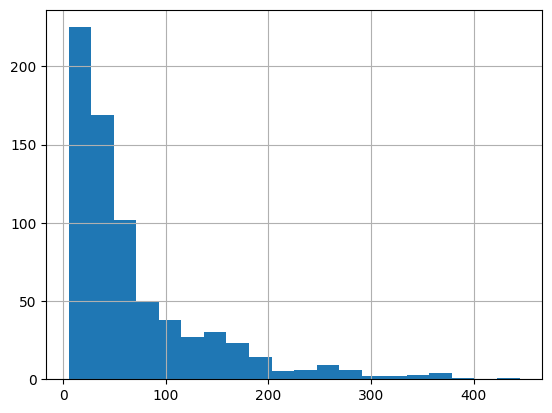

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 717
Total card age: 49634.63


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
716,Audit Report Tracker (Sharepoint List),List Administrator\nDefinition: A user with pe...,c04d54d96d16dfd514a229d890d7b6b4,-24.445644,24.445644,-24.445644,24.445644,0.007016,1,24.445644
571,Email Auth and Security,p=none\n\nA DMARC policy action.\nRequests no ...,98ed919f7e08cbf83347817d193116c3,-257.069869,102.832052,-257.069869,1233.984622,0.723108,12,257.069869
572,Email Auth and Security,Aggregate Reports\n\nSummary reports sent peri...,5c80cfa8657de0475b8c8f4c5cf6a911,-235.908758,102.832052,-257.069869,1233.984622,0.723108,12,257.069869
573,Email Auth and Security,SPF (Sender Policy Framework)\n\nA DNS-based e...,2c5dd2435fcdbaf7e688b35a78d91e32,-226.901982,102.832052,-257.069869,1233.984622,0.723108,12,257.069869
574,Email Auth and Security,"DMARC (Domain-based Message Authentication, Re...",c4082220e30760d5dd1f7dae8370acc9,-100.986809,102.832052,-257.069869,1233.984622,0.723108,12,257.069869
576,Email Auth and Security,Email Authentication Alignment\n\nEnsuring tha...,14bc6ca0af379197455f1cd5febad55c,-92.766542,102.832052,-257.069869,1233.984622,0.723108,12,257.069869
575,Email Auth and Security,PGP (Pretty Good Privacy)\n\nA data encryption...,e43853f9bc2f7722fa2b49997002d648,-90.709334,102.832052,-257.069869,1233.984622,0.723108,12,257.069869
577,Email Auth and Security,Feedback Loops (FBL)\n\nMechanisms by which em...,4c90f267d5996ebd5f6f67fab81061d5,-68.536655,102.832052,-257.069869,1233.984622,0.723108,12,257.069869
578,Email Auth and Security,p=quarantine\n\nA DMARC policy action.\nInstru...,ef938783fc320a6d315dde8501f4b254,-60.176914,102.832052,-257.069869,1233.984622,0.723108,12,257.069869
579,Email Auth and Security,MX Toolbox\n\nAn online suite of tools for dia...,e9ebe1455842da03c6a7da1503e46e12,-33.748165,102.832052,-257.069869,1233.984622,0.723108,12,257.069869


## Headers with greatest age sum first

In [8]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [10]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [11]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=10
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [14]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
164,Azure Developer Associate,Let's say you have compute workloads deployed ...,ac85c9e8d85ce50be39201db139bc927,-5.181100,98.797197,-361.159810,6026.629042,0.518350,61,361.159810
165,Azure Developer Associate,Type of Azure Container Registry authenticatio...,479458e1b339f5153c380c9b5d3d9922,-5.531894,98.797197,-361.159810,6026.629042,0.518350,61,361.159810
105,Vocab,"Jingo, Pratchett\nEquerry\nnoun | EK-wuh-ree\n...",e70e016f2f6d24855ab61927dd4dbef6,-5.945332,47.285645,-201.219404,5012.278341,0.887154,106,201.219404
161,Azure Developer Associate,Type of Azure Container Registry authenticatio...,2c6c4090c5baa34e50b0fcee05820253,-6.603308,98.797197,-361.159810,6026.629042,0.518350,61,361.159810
714,VMWare,Live Migration\n\nThe process of moving a runn...,beb3774c4f7f72e42fa1fa70a7e26a83,-6.685110,18.891769,-40.461855,812.346069,0.247848,43,40.461855
163,Azure Developer Associate,What's the recommended authentication method f...,92c7baf1544a3d6d4ced3a3057810fec,-7.081330,98.797197,-361.159810,6026.629042,0.518350,61,361.159810
103,Vocab,"Jingo, Pratchett\nPro tem\nadverb/adjective | ...",112b5b88bfde51d68292c8520c9d9436,-7.235396,47.285645,-201.219404,5012.278341,0.887154,106,201.219404
102,Vocab,"Jingo, Pratchett\nCrinoline\nnoun | KRIN-uh-li...",11b8182c8761879e9262b5797bbed0f4,-7.371660,47.285645,-201.219404,5012.278341,0.887154,106,201.219404
226,PnP PowerShell,Token Expiry\nThe duration an OAuth 2.0 access...,a25882e335343da6802e2a0689de2780,-7.614913,77.927076,-381.694839,4675.624540,0.676157,60,381.694839
162,Azure Developer Associate,Geo-replication enables a container registry t...,339c20d5e16e08f63569052309b38f5e,-7.781250,98.797197,-361.159810,6026.629042,0.518350,61,361.159810


In [18]:
existing_cards.head(10).sum()

head                   Audit Report Tracker (Sharepoint List)Email Au...
body                   List Administrator\nDefinition: A user with pe...
hash                   c04d54d96d16dfd514a229d890d7b6b498ed919f7e08cb...
age                                                         -1191.250671
subject_mean_age                                              949.934111
subject_highest_age                                         -2338.074467
subject_age_sum                                             11130.307246
head_random_roll                                                6.514986
frequency                                                            109
oldest                                                       2338.074467
dtype: object

In [19]:
existing_cards['age'].mean()

-69.22542847028699